# Show Content Scraper
> Author: Sharnique Beck
<hr>
Scrape show content (title, director, writer, cast, user average rating, network, genre, # episodes) from viki.com and asianwiki.com

In [601]:
# Import libaries
import pandas as pd
import numpy as np
import requests
import time
import re
import matplotlib.pyplot as plt

%matplotlib inline

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

from bs4 import BeautifulSoup

headers = {'User-agent': 'SB 2.0'}

In [3]:
shows = pd.read_csv('./data/k_titles.csv')
shows.head()

,title,url,container,rating,# ratings
0,Thirty But Seventeen,https://www.viki.com/tv/36109c-thirty-but-seve...,36109c,9.58,7368
1,Fates and Furies,https://www.viki.com/tv/36240c-fates-and-furies,36240c,9.14,1401
2,The Last Empress,https://www.viki.com/tv/36241c-the-last-empress,36241c,9.45,3858
3,Encounter,https://www.viki.com/tv/36239c-encounter,36239c,9.59,5436
4,My Strange Hero,https://www.viki.com/tv/36330c-my-strange-hero,36330c,9.56,2239


### Save Genre Codes

In [590]:
url='https://api.viki.io/v4/containers/genres.json?&app=100000a' 
res = requests.get(url, headers= headers)
soup = res.json()
genres = []
for g in soup:
    genre={}
    genre['id'] = g['id']
    genre['type'] = g['genre_type']
    genre['name'] = g['name']['en']
    genres.append(genre)

k_genres = pd.DataFrame(genres)
k_genres.to_csv('./data/genres.csv', index=False)

In [14]:
genre = pd.read_csv('./data/genres.csv')
genre.head()

### Get Cast Info

In [22]:
cast_cont= []

for row in range(len(shows)):
    s_cast={}
    show_url = shows['url'][row] + '#modal-casts'

    # use selenium webdriver as library that acts as a 
    # headless browser to access modal window
    driver = webdriver.Chrome()
    driver.implicitly_wait(30)
    driver.get(show_url)
    
    soup_1=BeautifulSoup(driver.page_source, 'lxml')
    time.sleep(1)
    
    # Scrape all cast members from show
    try:
        cast = soup_1.find_all('div',{'id':'modal-casts'})
        actors = cast[0].find_all('div',{'itemprop':'actor'})

        cast_lst = []
        for actor in range(len(actors)):
            name = actors[actor].find('span', {'itemprop':'name'}).text
            cast_lst.append(name)
        s_cast['title'] = shows['title'][row]
        s_cast['cast'] = cast_lst
        cast_cont.append(s_cast)
    
    # Run when shows have less than five cast members
    except IndexError:
        actors = soup_1.find_all('div',{'itemprop':'actor'})

        cast_lst = []
        for actor in range(1,len(actors)):
            name = actors[actor].find('span', {'itemprop':'name'}).text
            cast_lst.append(name)
        s_cast['title'] = shows['title'][row]
        s_cast['cast'] = cast_lst
        cast_cont.append(s_cast)
        
    # Run when shows have no cast info
    except:
        s_cast['title'] = shows['title'][row]
        s_cast['cast'] = []        
        
    #end the Selenium browser session
    driver.quit()

c_content = pd.DataFrame(cast_cont)
c_content.head()

In [74]:
c_content.to_csv('./data/cast.csv', index=False)

### Get other show info

In [ ]:
s_cont =[]

In [ ]:
# Find show ratings and # of ratings
for row in range(len(shows['container'])):
    url='https://api.viki.io/v4/containers/%s.json?app=100000a' %shows['container'][row]
    res = requests.get(url, headers= headers)
    json_pg = res.json()
    
    info ={}
    info['title'] = shows['title'][row]
    info['genre'] = json_pg['genres']
    info['s_rating'] = json_pg['rating']
    info['# episodes'] = json_pg['episodes']['count']
    info['network'] = json_pg['distributors'][0]['name']
    info['rating']= json_pg['review_stats']['average_rating']  
    s_cont.append(info)
    time.sleep(1)

s_contents = pd.DataFrame(s_cont)
s_contents.head()

In [ ]:
s_contents.to_csv('./data/s_contents.csv', index = False)

### Get Production info
from asianwiki website

In [133]:
p_cont = []

In [135]:
for row in range(len(shows)):
    
    # Search website using given show title 
    try:
        s_url='http://asianwiki.com/%s' %shows['s_title'][row] 
        res = requests.get(s_url, headers = {'User-agent': 'SB 2.0'})
        soup = BeautifulSoup(res.content, 'lxml')

        info = soup.find('div',{'id':'mw-content-text'})
        table = info.find_all('ul')

        content = {}
        content['title'] = shows['title'][row]
        content['director'] = re.findall('Director:\s(.+)', table[1].text)[0]
        content['screenwriter'] = re.findall('Writer:\s(.+)', table[1].text)[0]
        p_cont.append(content)

        time.sleep(1)
    
    # Run when page does not match show title format
    except:
        s_url='http://asianwiki.com/%s' %shows['s_title'][row] 
        res = requests.get(s_url, headers = {'User-agent': 'SB 2.0'})
        soup = BeautifulSoup(res.content, 'lxml')
        
        content = {}
        content['title'] = shows['title'][row]
        content['director'] = []
        content['screenwriter'] = []
        p_cont.append(content)

        time.sleep(1)

p_content = pd.DataFrame(p_cont)

In [587]:
p_content.head()

,director,screenwriter,title
0,Jo Soo-Won,Jo Sung-Hee,Thirty But Seventeen
1,Jung Dong-Yoon,Kang Cheol-Woong,Fates and Furies
2,Joo Dong-Min,Kim Sun-Ok,The Last Empress
3,Park Shin-Woo,Yoo Young-A,Encounter
4,Ham Joon-Ho,Kim Yoon-Young,My Strange Hero


### Find Titles that did not store information

In [586]:
for show in range(p_content.shape[0]):
    if type(p_content['director'][show])!= str:
        print (p_content['title'][show],show)

UNDER NINETEEN 48
Master in the House 64
The Return of Superman 67
2 Days and 1 Night 81
Wind-bell 85
THE FAN 123
It’s Dangerous Beyond The Blankets 192
The Manager 197
We Got Married 203
Village Survival, the Eight 207
Happy Together 218
The Master Key 252
The Unit 257
BTS Comeback Show 262
Immortal Songs 266
Dancing High 295
Hot and Sweet 309
After School Club 315
Wanna One Go: Zero Base 324
2018 SBS Drama Awards 326
Unexpected Heroes 327
2018 KBS Drama Special 331
Rebel Detectives 336
Infinite Challenge 341
Simply K-pop 343
The Facetale: Cinderia 344
It’s Dangerous Beyond The Blanke... 345
Here Comes Trouble S4 346
2018 Idol Star Athletics Champio... 350
Sister's Slam Dunk 364
2018 KBS Song Festival 365
Fantastic Duo 2 369
Matching! Boys Archery 372
Yu Huiyeol’s Sketchbook 375
SBS Inkigayo 377
Pets GO! Doggy Trip 393
Showbiz Korea 395
Battle Trip 396
Hotelier 397
2018 MBC Music Festival 398
Love in Memory 400
Special Laws of Romance 401
2018 Idol Star Athletics Champio... 402
2018 S

### Manually find production info
Use the following website to verify and set info
* http://asianwiki.com/index.php?
* https://mydramalist.com/
* https://wiki.d-addicts.com

In [583]:
s_url= "http://asianwiki.com/Assembly_(Korean_Drama)"            # Use given url to find production info
res = requests.get(s_url, headers = {'User-agent': 'SB 2.0'})
soup = BeautifulSoup(res.content, 'lxml')

info = soup.find('div',{'id':'mw-content-text'})
table = info.find_all('ul')

p_content.loc[615,'director'] = re.findall('Director:\s(.+)', table[1].text)[0]   # Collect and Set Director name(s)
p_content.loc[615,'screenwriter'] = re.findall('Writer:\s(.+)', table[1].text)[0]    # Collect and Set Writer name(s)

In [592]:
p_content.head()

,director,screenwriter,title
0,Jo Soo-Won,Jo Sung-Hee,Thirty But Seventeen
1,Jung Dong-Yoon,Kang Cheol-Woong,Fates and Furies
2,Joo Dong-Min,Kim Sun-Ok,The Last Empress
3,Park Shin-Woo,Yoo Young-A,Encounter
4,Ham Joon-Ho,Kim Yoon-Young,My Strange Hero


In [589]:
p_content.to_csv('./data/p_contents.csv', index = False)

### Concat data

In [605]:
# Check Dataframe sizes to be merged
print('Show content size:', s_cont.shape)
print('Cast content size:', c_content.shape)
print('Production content size:', p_content.shape)

Show content size: (624, 6)
Cast content size: (624, 2)
Production content size: (624, 3)


In [595]:
show_info = pd.concat([s_cont,c_content['cast'],p_content['director'],p_content['screenwriter']],axis=1)

In [597]:
show_info.head()

,# episodes,genre,network,rating,s_rating,title,cast,director,screenwriter
0,32,"['23g', '9g', '18g', '6g', '7g']",SBS,9.58,PG-13,Thirty But Seventeen,"[Shin Hye Sun, Yang Se Jong, Ahn Hyo Seop, Ye ...",Jo Soo-Won,Jo Sung-Hee
1,36,"['18g', '1041g', '23g']",SBS,8.73,PG-13,Fates and Furies,"[Joo Sang Wook, Lee Min Jung, Lee Ki Woo, So Y...",Jung Dong-Yoon,Kang Cheol-Woong
2,42,"['23g', '9g', '18g']",SBS,9.45,PG-13,The Last Empress,"[Shin Sung Rok, Jang Nara, Choi Jin Hyuk, Shin...",Joo Dong-Min,Kim Sun-Ok
3,16,"['18g', '23g']",tvN,9.56,PG-13,Encounter,"[Park Bo Gum, Song Hye Kyo, Jang Seung Jo, P.O...",Park Shin-Woo,Yoo Young-A
4,32,"['18g', '1041g', '9g', '23g']",SBS,9.55,PG-13,My Strange Hero,"[Yoo Seung Ho, Jo Bo Ah, Kwak Dong Yeon, Yoo S...",Ham Joon-Ho,Kim Yoon-Young


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132e11ef0>,
      dtype=object)

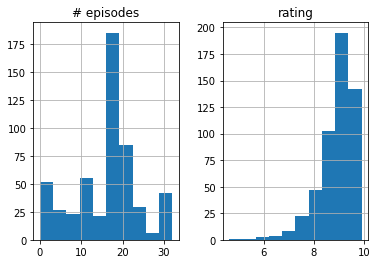

In [603]:
show_info[show_info['# episodes']<33].hist()

In [606]:
show_info.to_csv('./data/show_info.csv', index = False)

In [246]:
s_cont = pd.read_csv('./data/s_contents.csv')
s_cont.drop(columns=['cast'], inplace=True)
s_cont.head(86)

,# episodes,genre,network,rating,s_rating,title
0,32,"['23g', '9g', '18g', '6g', '7g']",SBS,9.58,PG-13,Thirty But Seventeen
1,36,"['18g', '1041g', '23g']",SBS,8.73,PG-13,Fates and Furies
2,42,"['23g', '9g', '18g']",SBS,9.45,PG-13,The Last Empress
3,16,"['18g', '23g']",tvN,9.56,PG-13,Encounter
4,32,"['18g', '1041g', '9g', '23g']",SBS,9.55,PG-13,My Strange Hero
5,16,"['23g', '1038g', '18g']",tvN,9.72,PG-13,What’s Wrong With Secretary Kim
6,16,"['18g', '23g']","MBN, Dramax",9.15,PG-13,Devilish Joy
7,33,"['9g', '23g', '6g', '18g']",MBC,9.67,PG-13,I Am Not a Robot
8,40,"['23g', '9g', '18g', '6g', '26g']",SBS,9.63,PG-13,Suspicious Partner
9,16,"['18g', '20g', '9g', '23g']",MBC,9.75,PG-13,Weightlifting Fairy Kim Bok Joo


In [ ]:
s_contents['s_rating'].value_counts()

In [118]:
shows['s_title']=shows['title'].map(lambda x: x.replace(' ','_'))

In [119]:
shows.head()

,title,url,container,rating,# ratings,s_title
0,Thirty But Seventeen,https://www.viki.com/tv/36109c-thirty-but-seve...,36109c,9.58,7368,Thirty_But_Seventeen
1,Fates and Furies,https://www.viki.com/tv/36240c-fates-and-furies,36240c,9.14,1401,Fates_and_Furies
2,The Last Empress,https://www.viki.com/tv/36241c-the-last-empress,36241c,9.45,3858,The_Last_Empress
3,Encounter,https://www.viki.com/tv/36239c-encounter,36239c,9.59,5436,Encounter
4,My Strange Hero,https://www.viki.com/tv/36330c-my-strange-hero,36330c,9.56,2239,My_Strange_Hero


In [ ]:
s_info =[]

In [122]:
url3='http://asianwiki.com/Thirty_But_Seventeen' #%shows['s_title'][21] 
res = requests.get(url3, headers = {'User-agent': 'SB 2.0'})
soup = BeautifulSoup(res.content, 'lxml')

info = soup.find('div',{'id':'mw-content-text'})
table = info.find_all('ul')


In [125]:
table[1]

<ul><li> <b>Drama:</b> Still 17 (English title) / Thirty But Seventeen (literal title)
</li><li> <b>Revised romanization:</b> Seoreunijiman Yeolilgobibmida
</li><li> <b>Hangul:</b> 서른이지만 열일곱입니다
</li><li> <b>Director:</b> <a href="/Jo_Soo-Won_(director)" title="Jo Soo-Won (director)">Jo Soo-Won</a>
</li><li> <b>Writer:</b> <a href="/Jo_Sung-Hee_(screenwriter)" title="Jo Sung-Hee (screenwriter)">Jo Sung-Hee</a>
</li><li> <b>Network:</b> <a href="/SBS" title="SBS">SBS</a>
</li><li> <b>Episodes:</b> 32
</li><li> <b>Release Date:</b> July 23 - September 18, 2018
</li><li> <b>Runtime:</b> Monday &amp; Tuesday 22:00 (35 minutes each / 2 episodes per day)
</li><li> <b>Language:</b> Korean
</li><li> <b>Country:</b> South Korea
</li></ul>